In [1]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [3]:
# import the dataset
url='https://drive.google.com/file/d/1XN0P7t7koCNMcpFDTdhWQAQpv_G6yf6C/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
bank_df = pd.read_csv(url, sep=';')
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Preprocessing

In [4]:
bank_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
# a look at the categories and values so that unknown categories can be removed as a row
for col in bank_df:
    print(col)
    print(bank_df[col].unique())

age
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital
['married' 'single' 'divorced' 'unknown']
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default
['no' 'unknown' 'yes']
housing
['no' 'yes' 'unknown']
loan
['no' 'yes' 'unknown']
contact
['telephone' 'cellular']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
duration
[ 261  149  226 ... 1246 1556 1868]
campaign
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
pdays
[999

In [6]:
# size before unknown removal
bank_df.shape[0]

41188

In [7]:
# remove unknown categories
for col in bank_df:
    bank_df = bank_df[bank_df[col] != 'unknown']

In [8]:
# size after unknown categories
bank_df.shape[0]

30488

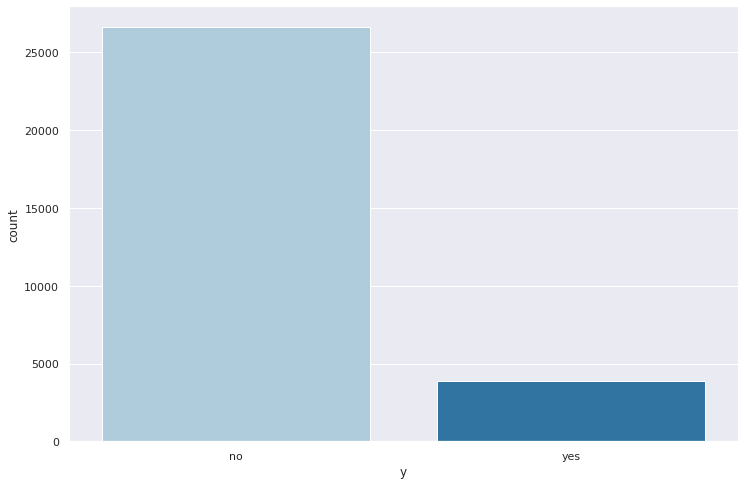

In [9]:
# take a look at the target category
sns.countplot(data=bank_df,x='y')

In [10]:
bank_df.y.value_counts()

no     26629
yes     3859
Name: y, dtype: int64

Label Encoder

In [11]:
# label encode the categorcal variables so that they can be fed into the decision tree model
le = LabelEncoder()
bank_df.job = le.fit_transform(bank_df.job)
bank_df.marital = le.fit_transform(bank_df.marital)
bank_df.education = le.fit_transform(bank_df.education)
bank_df.default = le.fit_transform(bank_df.default)
bank_df.housing = le.fit_transform(bank_df.housing)
bank_df.loan = le.fit_transform(bank_df.loan)
bank_df.contact = le.fit_transform(bank_df.contact)
bank_df.month = le.fit_transform(bank_df.month)
bank_df.day_of_week = le.fit_transform(bank_df.day_of_week)
bank_df.poutcome = le.fit_transform(bank_df.poutcome)
bank_df.y = le.fit_transform(bank_df.y)

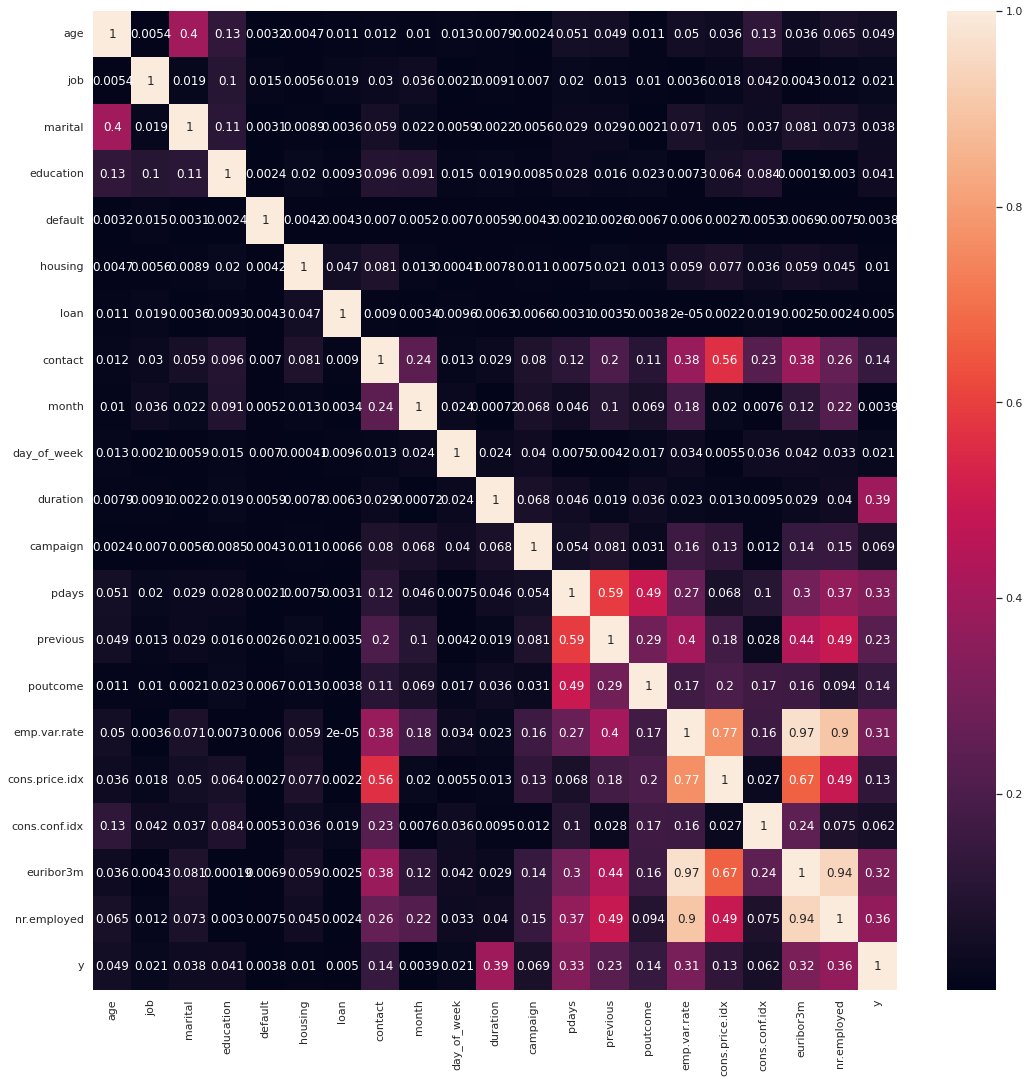

In [12]:
# a correlation heatmap can now be created after the preprocessing steps for further EDA
plt.figure(figsize=(18,18))
map = sns.heatmap(bank_df.corr().abs(),annot=True)

### Split data

In [13]:
# perform a split of the data into training and test data
X = bank_df.drop('y',axis=1)
y = bank_df[['y']]

K-Fold

In [14]:
# do a stratified k fold to allow for more even train and test groups in terms of the target category
KF = KFold(n_splits=3,shuffle=True)
for train_index, test_index in KF.split(X):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [15]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(20326, 20)
Test data shape:(10162, 20)


Scaling data

In [16]:
# scale the training and test data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

## Decision Tree Model

In [17]:
# define the model
dt = DecisionTreeClassifier()

In [18]:
# fit the model
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [19]:
# make predictions of the test data
pred = dt.predict(scaled_test)

In [20]:
# calculate the accuracy of the predictions by comparing to the test data
accuracy_score(y_test,pred)

0.8794528636095257

In [21]:
# define the grid search parameters
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [22]:
# perform the grid search
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [23]:
# display best parameters found from the grid search
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [24]:
# define the tuned decision tree with new parameters
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=2,
                                   max_depth=2,
                                   max_features = 'auto',
                                   min_samples_leaf=1,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features='auto',
                       random_state=0)

In [25]:
# create the new predictions
pred = dt_tuned.predict(scaled_test)

In [26]:
# display the accuracy of the tuned model
accuracy_score(y_test,pred)

0.8751230072820311

In [27]:
# display a classification report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      8893
           1       0.00      0.00      0.00      1269

    accuracy                           0.88     10162
   macro avg       0.44      0.50      0.47     10162
weighted avg       0.77      0.88      0.82     10162



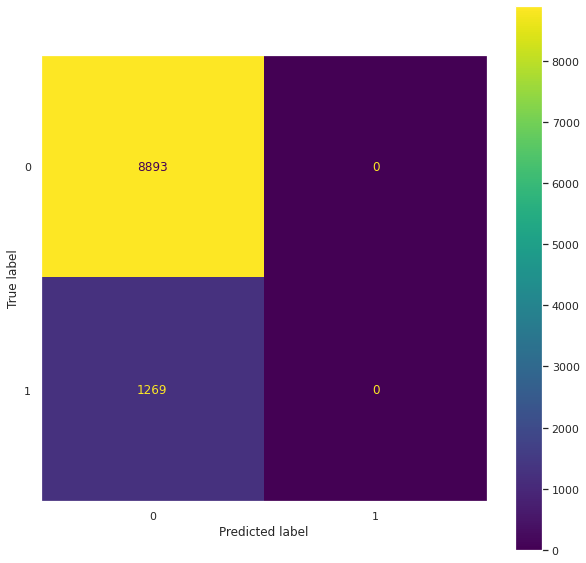

In [28]:
# display a confusion matrix to show where the predictions lie
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

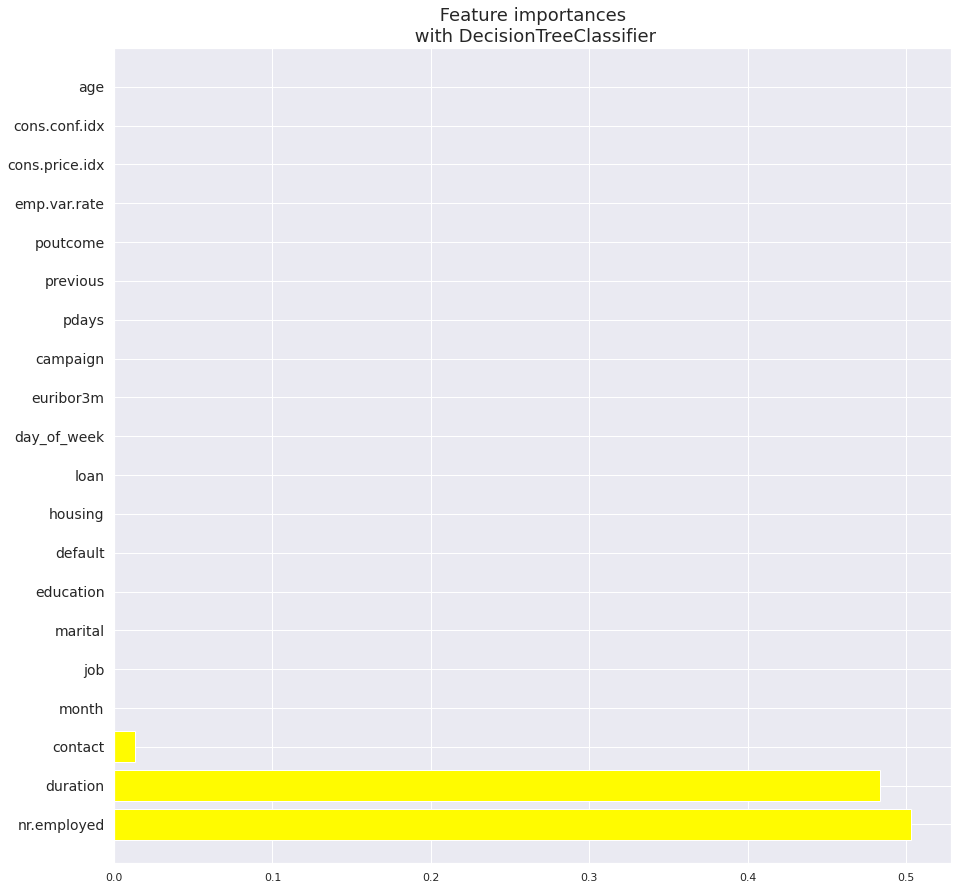

In [29]:
# display feature importance for the model
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = bank_df.drop('y', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

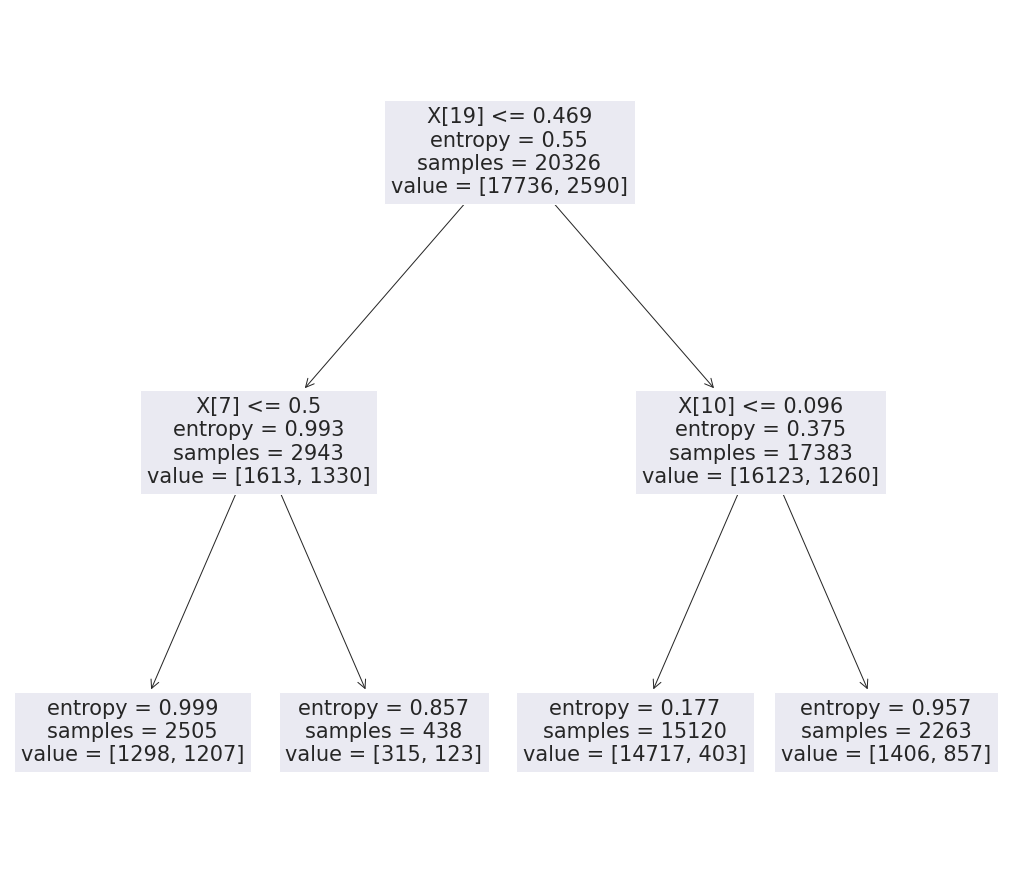

In [30]:
# example of the decision tree classifier display
plt.figure(figsize = (18, 16))
tree.plot_tree(dt_tuned)
plt.show()

In [31]:
# create a reults dataframe to compare accuracies of the different subgroups in the protected category
marital_results = pd.DataFrame(data = x_test, columns=['marital'])
marital_results['y_test'] = y_test
marital_results['pred'] = pred

In [32]:
marital_results['y_test'].replace(0, 'No', inplace=True)
marital_results['y_test'].replace(1, 'Yes', inplace=True)
marital_results['pred'].replace(0, 'No', inplace=True)
marital_results['pred'].replace(1, 'Yes', inplace=True)
marital_results['marital'].replace(0, 'Divorced', inplace=True)
marital_results['marital'].replace(1, 'Married', inplace=True)
marital_results['marital'].replace(2, 'Single', inplace=True)

marital_results.head()

,marital,y_test,pred
3,Married,No,No
4,Married,No,No
9,Single,No,No
14,Married,No,No
16,Married,No,No


In [33]:
# create a dataframe of only divorced predicted and true values
marital_results_div = marital_results[marital_results['marital']=='Divorced']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_div['true']  = np.where((marital_results_div['y_test'] == marital_results_div['pred']), 1, 0)
# calculate percentage of correct classifications
div_accuracy = (sum(marital_results_div['true'])/marital_results_div.shape[0])*100
div_accuracy

87.64805414551607

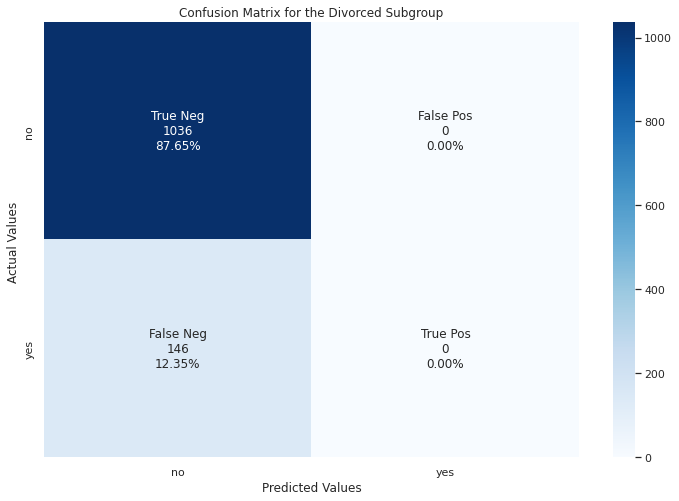

In [34]:
# a confusion matrix of one of the subgroups in the protected category
y_test = marital_results_div['y_test']
pred = marital_results_div['pred']
div_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                div_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     div_cf.flatten()/np.sum(div_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(div_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Divorced Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['no','yes'])
ax.yaxis.set_ticklabels(['no','yes'])

plt.show()

In [35]:
# create a dataframe of only married predicted and true values
marital_results_mar = marital_results[marital_results['marital']=='Married']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_mar['true']  = np.where((marital_results_mar['y_test'] == marital_results_mar['pred']), 1, 0)
# calculate percentage of correct classifications
mar_accuracy = (sum(marital_results_mar['true'])/marital_results_mar.shape[0])*100
mar_accuracy

88.71159395688338

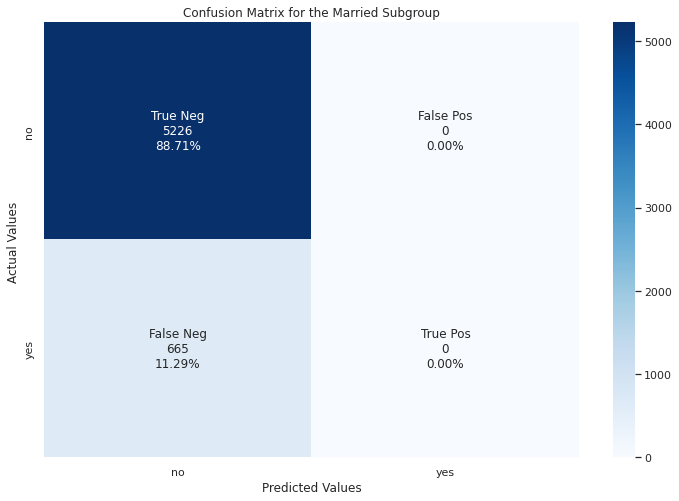

In [36]:
# a confusion matrix of one of the subgroups in the protected category
y_test = marital_results_mar['y_test']
pred = marital_results_mar['pred']
mar_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                mar_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     mar_cf.flatten()/np.sum(mar_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(mar_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Married Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['no','yes'])
ax.yaxis.set_ticklabels(['no','yes'])

plt.show()

In [37]:
# create a dataframe of only single predicted and true values
marital_results_sin = marital_results[marital_results['marital']=='Single']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_sin['true']  = np.where((marital_results_sin['y_test'] == marital_results_sin['pred']), 1, 0)
# calculate percentage of correct classifications
sin_accuracy = (sum(marital_results_sin['true'])/marital_results_sin.shape[0])*100
sin_accuracy

85.17319520880544

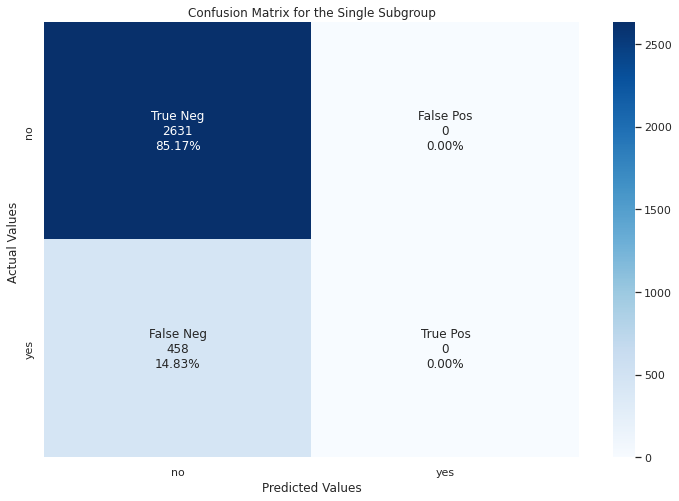

In [38]:
# a confusion matrix of one of the subgroups in the protected category
y_test = marital_results_sin['y_test']
pred = marital_results_sin['pred']
sin_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                sin_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     sin_cf.flatten()/np.sum(sin_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(sin_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Single Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['no','yes'])
ax.yaxis.set_ticklabels(['no','yes'])

plt.show()

In [39]:
from tabulate import tabulate
data = [['Divorced', div_accuracy],
['Married', mar_accuracy],
['Single', sin_accuracy]]
print (tabulate(data, headers=["Marital Status", "Classification Accuracy"]))

Marital Status      Classification Accuracy
----------------  -------------------------
Divorced                            87.6481
Married                             88.7116
Single                              85.1732
